In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.128126  0.495794 -0.004281  0.658116  0.151410  0.135987 -0.513016   
  1   0.067266 -0.633083 -0.987175 -0.360753 -0.359001 -0.717178 -0.035137   
  2  -0.157313 -0.262092 -0.571593  0.266738 -0.057115 -0.336638  0.222891   
  3  -0.228251 -1.078295 -0.387677  0.095855 -0.520962 -0.938112  0.672592   
  4   0.466331 -0.222716  0.664192  0.278493  0.198011 -0.012483 -0.083446   
  5  -0.308536 -0.358326  0.191827  0.853876  0.040750 -0.408792  0.418148   
  6   0.409474 -0.075531  0.410392  0.246691  0.636891  0.341672 -0.144693   
  7  -0.460869 -0.561494  0.649923  0.145826 -0.117057 -0.238911 -0.407242   
  8  -0.889152 -0.914221 -0.006589 -0.030171  0.382735 -0.515232 -0.224480   
  9   0.174385  0.859866  0.872219  0.546273  0.230957 -0.916465 -0.456944   
  10 -0.825852  0.058091 -1.143043 -0.395718  0.639217  0.401218  0.230694   
  11  0.685082 -0.363846 -0.774532  0.099715  0.768543 -1.090938 -0.894682   
  12 -0.893863 -0.797799 -0.217455  0.567575 -0.119442 -0.712917 -0.532711   
  13  0.459055  1.259196  0.930006  0.587843 -0.371074 -0.025488 -0.974760   
  14 -0.366241  0.033284 -0.022594 -0.124614 -1.265893 -0.735799  0.756963   
  15 -0.313017 -0.792525  0.699317  0.514081 -0.361369 -0.893636 -0.286361   
  16 -0.540837  0.527379  0.180787  0.182389 -0.379971 -0.350107  0.246425   
  17 -0.238763  0.548366  0.177917 -0.772533  0.155719 -0.673749 -1.140615   
  18 -0.166774 -0.071410 -0.394020 -0.152174  0.534799 -0.211279  0.678307   
  19 -0.873037 -0.293496  0.193936  0.542399 -1.056255 -0.321613  0.616709   
  20  0.147343  0.449544 -0.641475  0.366866  0.382328 -0.647021  0.523420   
  21 -0.270568 -0.644113  0.440607 -0.311264  0.691733 -0.759987 -0.262356   
  22 -0.708324 -0.660501 -0.388442 -0.284225  0.369253  0.293671  1.069314   
  23  0.012020 -0.023227 -0.524207  0.600893 -0.318847 -0.775523  0.224422   
  24  0.177262 -0.536237 -0.346460 -0.309628 -1.017497 -1.533059 -0.663342   
1 0   0.745238  0.575680 -0.266383 -1.613962  0.005151  0.112865  0.269334   
  1   1.449219  0.936436 -0.181008  0.615005  0.448983 -0.334821 -0.119564   
  2   0.846909  0.075414 -0.909755 -1.171524 -0.131895 -0.138895  0.387412   
  3  -0.310654  1.061308 -0.351706  0.935610  0.752694  0.481920  1.300934   
  4   0.905220  0.156706 -0.912035 -1.493789 -0.808779 -0.725573 -0.420236   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.722352 -0.676221  0.141542  ...  0.038754  0.274445 -0.554630   
  1  -0.489273  0.426651  0.353527  ... -1.273491 -0.441919 -0.092597   
  2   0.206581 -0.195353 -0.121001  ... -0.070435 -0.495077 -0.782970   
  3   0.044746  1.339768 -0.104087  ... -0.098827  0.219036 -0.324066   
  4   0.455668 -0.155136  0.258310  ...  0.253202 -0.502085 -0.908442   
  5   1.020435  1.369109  0.813184  ...  0.025087  0.020257 -0.188710   
  6  -0.720568 -0.531631 -0.626017  ... -0.034770  0.184737 -1.298267   
  7  -0.135070  0.998434  0.562795  ...  0.391926 -1.014590 -0.795163   
  8  -0.336182 -0.282242  1.483827  ... -0.704106  0.035352 -0.369837   
  9  -0.159158  0.380790  0.696852  ... -0.796173  0.303214 -0.272789   
  10  0.120730 -0.080959  0.055616  ...  0.229626 -0.985352 -1.158550   
  11 -1.010583  0.075380 -0.148695  ... -0.717524 -0.715885 -1.330594   
  12 -1.002365 -0.249813  0.105418  ...  0.029773 -0.189541 -1.193603   
  13 -0.616601 -0.445397 -0.160733  ... -0.308772 -0.098731 -0.397405   
  14 -0.606389 -0.268581  0.317861  ... -0.110814  0.665103 -0.171062   
  15 -0.271241 -1.021578 -0.166602  ...  0.060130 -0.390768 -0.417549   
  16  0.228652  0.281372  1.201065  ...  0.298270 -0.315774 -0.862144   
  17 -0.807794  0.408553  1.560390  ... -0.071175 -0.170107 -0.620026   
  18 -0.721018  0.141752  0.843169  ... -0.403945 -0.427169  0.619578   
  19 -0.496049 -1.004081 -0.771964  ... -0.362754  0.294653  0.001182   
  20 -0.213692  0.894452 -0.726650  ... -0.476422 -0.977230 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef  std err          t          P>|t|     2.5 %    97.5 %
D  1.077542  0.04358  24.725811  5.645505e-135  0.992128  1.162957


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



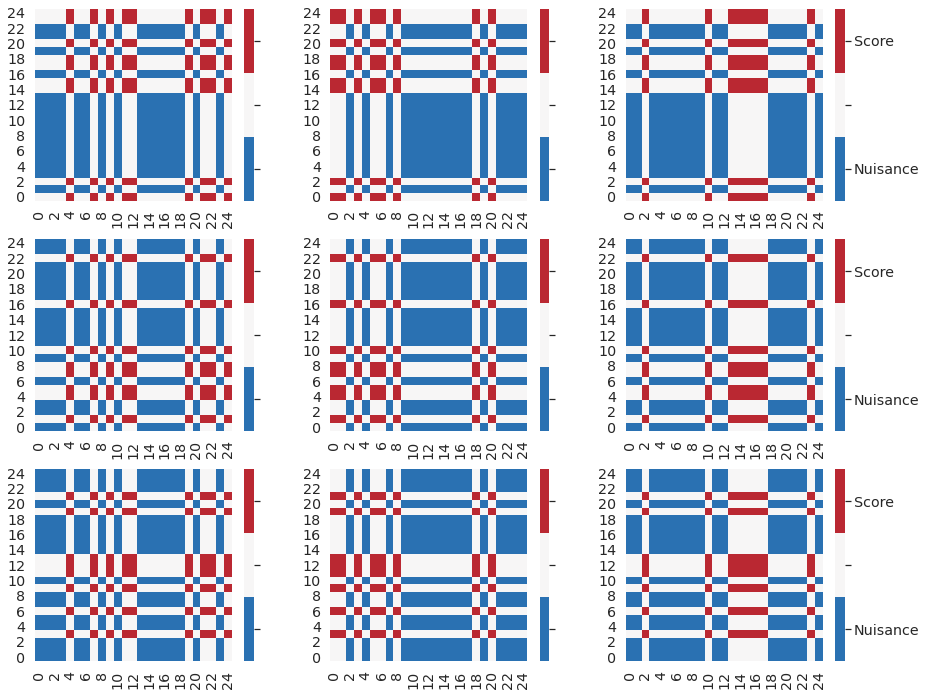

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



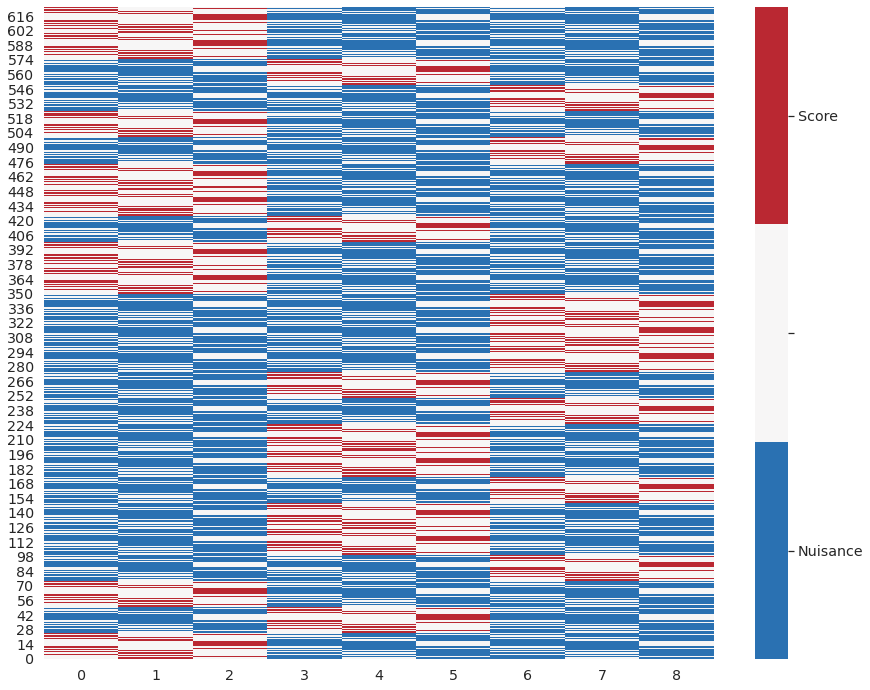

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])